In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange
from importlib import reload

import utils.policies as polc
import utils.experiment as expt
import utils.misc as mutil
import utils.network as qnet

reload(polc)
reload(expt)
reload(qnet)
reload(mutil);

## Simulation Parameters

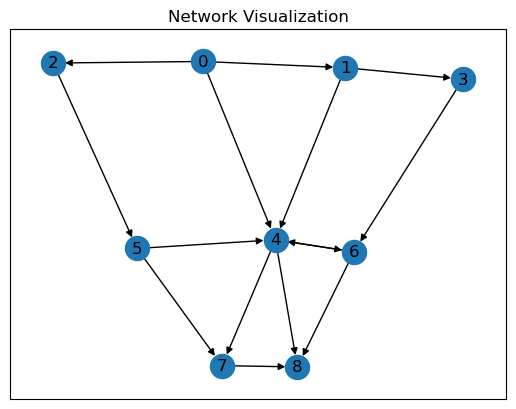

In [2]:
# simulation lengths
T_horizon = 10000 # time horizon (to be set later)
N_runs = 100 # number of simulations

# noise and arrival rates
def random_uniform(size = []):
    return 2*np.random.uniform(size = size)-1
noise_distribution = random_uniform # np.random.standard_normal
noise_variance = 0.1 # sigma^2
arrival_rate   = 4  # lambda

# algorithm parameters
beta  = 5*noise_variance # exploration tuner (should theoretically be > 4 sigma^2)
nu    = None # backlog-cost tradeoff tuner (should theoretically be T^{1/3}) (to be set later)
delta = None # exploration tuner (should theoretically be T^{(-2 sigma^2)/(beta - 2 sigma^2)}) (to be set later)

# topology
N_nodes          = 9
source_node      = 0
destination_node = 8
edges_list       = [[0,1], [0,4], [0,2], [1,3], [1,4], [2,5], [3,6], [6,4], [4,6], [4,7], [5,4], [5,7], [6,8], [4,8], [7,8]]
node_edge_adjacency = mutil.prepare_adjacency(edges_list, N_nodes)

# edge properties
edge_capacities = np.array([4,2,2,2,2,2,2,1,1,1,1,1,2,5,2]) # max-flow = 8
true_edge_costs = np.array([2,5,1,1,2,1,1,1,1,1,1,3,3,1,1])/10

# pack parameters
simulation_params = mutil.SimulationParameters(node_edge_adjacency, 
                 true_edge_costs, edge_capacities, 
                 source_node, destination_node, 
                 noise_variance, noise_distribution,
                 arrival_rate, 
                 N_runs, T_horizon, 
                 beta, delta, nu)

# visualize topology
mutil.visualize_network(edges_list, N_nodes)

## Static Policy

In [3]:
stat_edge_rates = polc.get_static_policy(node_edge_adjacency, source_node, destination_node, true_edge_costs, edge_capacities, arrival_rate)
stat_cost_at_tt = stat_edge_rates@true_edge_costs

## DPOP Policy

In [4]:
# intialization
T_horizon_next = 1
my_network = qnet.OnlineQueueNetwork(simulation_params)
while(T_horizon_next < T_horizon):
    # T doubling step
    T_horizon_next = min(2*T_horizon_next, T_horizon)

    # change parameters for this value of T
    simulation_params = expt.set_simulation_params(simulation_params, T_horizon_next)
    my_network.T_horizon = T_horizon_next

    # run experiment for this value of T
    my_network = expt.run_experiment(simulation_params, policy = 'dpop', custom_seed = 13, queueing_network = my_network)
    
# save cost and backlog values
tran_cost_at_tt, backlog_at_tt = expt.calculate_per_time_metrics(my_network)
tran_cost_till_tt, backlog_cost_at_tt = expt.calculate_total_costs(my_network)
dpop_regret = tran_cost_till_tt + backlog_cost_at_tt - stat_cost_at_tt*np.arange(0,T_horizon)

## Oracle Policy

In [ ]:
# change parameters for this value of T
simulation_params.noise_variance = 0
simulation_params = expt.set_simulation_params(simulation_params, T_horizon)

# run experiment for this value of T
oracle_network = expt.run_experiment(simulation_params, policy = 'dpop', custom_seed = 13)

# save cost and backlog values
oracle_cost_at_tt, oracle_backlog_at_tt = expt.calculate_per_time_metrics(oracle_network)
oracle_tran_cost_till_tt, oracle_backlog_cost_at_tt = expt.calculate_total_costs(oracle_network)
oracle_regret = oracle_tran_cost_till_tt + oracle_backlog_cost_at_tt - stat_cost_at_tt*np.arange(0,T_horizon)

## Results Comparison

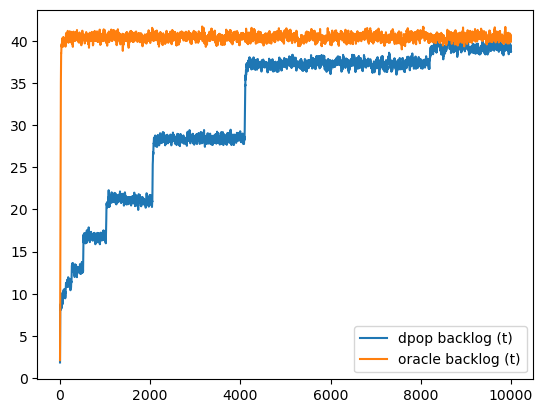

In [ ]:
plt.plot(backlog_at_tt, label = 'dpop backlog (t)')
plt.plot(oracle_backlog_at_tt, label = 'oracle backlog (t)')
plt.legend()
plt.show()

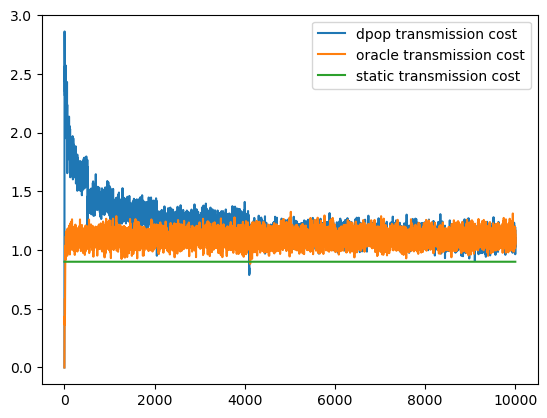

In [ ]:
plt.plot(tran_cost_at_tt, label = 'dpop transmission cost(t)')
plt.plot(oracle_cost_at_tt, label = 'oracle transmission cost(t)')
plt.plot(stat_cost_at_tt*np.ones(tran_cost_at_tt.shape), label = 'static transmission cost(t)')
plt.legend()
plt.show()

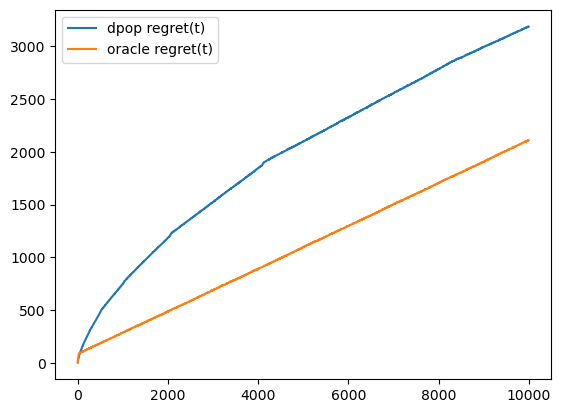

In [ ]:
plt.plot(dpop_regret, label = 'dpop regret(t)')
plt.plot(oracle_regret, label = 'oracle regret(t)')
plt.legend()
plt.show()